In [145]:
# pip install tscluster

In [146]:
# pip install statsmodels

# Imports

In [1]:
from __future__ import annotations

import time
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import numpy.typing as npt
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import Lasso

import matplotlib.pyplot as plt

from tscluster.tskmeans import TSKmeans
from tscluster.tsplot import tsplot as tsp

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer

from codes.utils import gen_synthetic_data
from codes.model.gct_model import GrangeCausalTree
from codes.model.baseline_models import ARTSC, KMW, AggLR
from codes.metrics import calculate_purity, par_set_accuracy

In [2]:
T = 20
N = 60
F = 3

K = 3
entities_per_cluster = N // K

true_set = {0: (0, 1), 1: (0,), 2: (2,)}

feature_noise_sigma = 1
target_noise_sigma = 0.2
n_lags = 2
random_state = 0

ts_arr = gen_synthetic_data(T=T, N=N, F=F, K=K, entities_per_cluster=entities_per_cluster,
                            target_noise_sigma=target_noise_sigma, feature_noise_sigma=feature_noise_sigma,
                            n_lags=n_lags, true_set=true_set, random_state=random_state)

pd.DataFrame(ts_arr[:, :, -1]).describe()


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,-1.478315,-6.490654,-0.140834,0.560405,0.776531,-0.446806,-0.615432,-2.364763,-0.261457,5.705720,...,0.435546,-1.644382,1.589326,-0.199603,0.516508,1.400214,-1.247193,0.034684,-2.077517,-1.624552
std,3.015547,2.897579,1.390674,1.913966,1.516712,2.069599,1.188017,2.309849,1.373876,2.940563,...,1.184338,1.527981,1.198328,1.911205,1.196395,1.681389,1.617829,1.204492,2.192017,1.631806
min,-6.717334,-10.470265,-2.824928,-2.434996,-1.982669,-3.930800,-2.286311,-6.737078,-3.075233,0.937943,...,-1.753199,-5.717187,-0.970668,-4.363706,-1.360304,-1.567838,-3.988424,-2.348659,-6.280013,-4.719513
25%,-4.159321,-8.605205,-1.165778,-0.593670,-0.119724,-2.016595,-1.317555,-3.940339,-1.286339,2.662426,...,-0.420451,-2.333691,0.757874,-1.324215,-0.389444,0.082537,-2.122029,-0.911924,-3.823974,-2.592767
50%,-0.987755,-6.731585,-0.261878,0.116815,0.664765,-0.697388,-0.636215,-2.471476,-0.342443,6.707726,...,0.381915,-1.699517,1.524316,0.237234,0.501001,1.947054,-1.277628,0.271919,-1.654969,-1.226247
75%,0.689455,-5.801683,1.067464,1.486865,1.582972,0.863643,0.030377,-0.506949,0.868471,7.533009,...,1.512990,-0.499246,2.413768,1.068962,1.057664,2.504794,-0.040237,0.970770,-0.227401,-0.360976
max,3.312583,0.341276,2.145394,5.253602,4.176113,3.561783,2.888715,1.301190,2.332890,9.438488,...,1.990273,0.910252,3.385899,3.360837,3.719852,4.183268,1.449353,1.926797,0.928080,0.795594


In [3]:
pd.DataFrame(ts_arr[:, 10:20, -1]).describe()

,0,1,2,3,4,5,6,7,8,9
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,1.998671,3.073126,0.795488,-1.070133,2.694121,-3.297834,2.200673,0.642868,0.807759,0.178076
std,2.173288,2.426698,2.033385,1.442141,2.887701,2.548479,1.545782,4.625208,1.967835,2.262210
min,-1.942384,-0.966257,-3.390840,-3.511187,-1.722649,-8.384179,-0.285151,-9.068978,-3.343204,-3.937054
25%,0.660469,1.139661,-0.301301,-2.222942,0.598514,-5.042029,1.022459,-0.811379,-0.464435,-0.816650
50%,2.253158,2.515864,0.617476,-0.966448,2.004803,-3.095655,2.077389,0.379465,0.734723,0.231581
75%,3.263101,5.105831,2.388455,-0.310756,4.392533,-0.953805,3.358475,2.543334,2.221867,1.036099
max,7.031149,7.322220,4.183063,1.923391,9.156742,-0.082994,4.687784,9.391813,5.079191,6.393702


In [4]:
ts_arr.shape

(20, 60, 4)

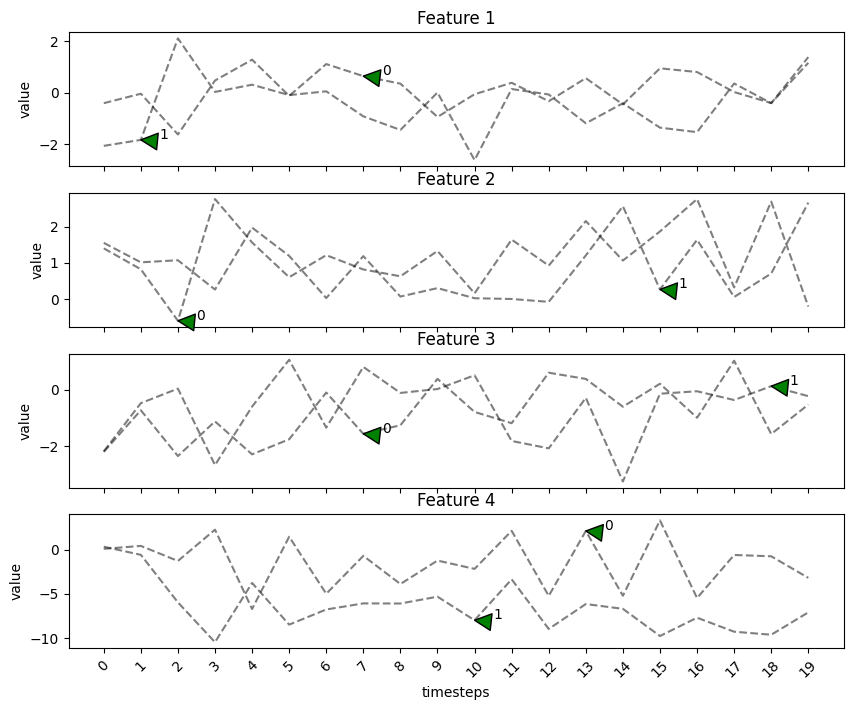

In [5]:
fig_ax = tsp.plot(X=ts_arr, entity_idx=[0, 1], show_all_entities=False, figsize=(10, 8))

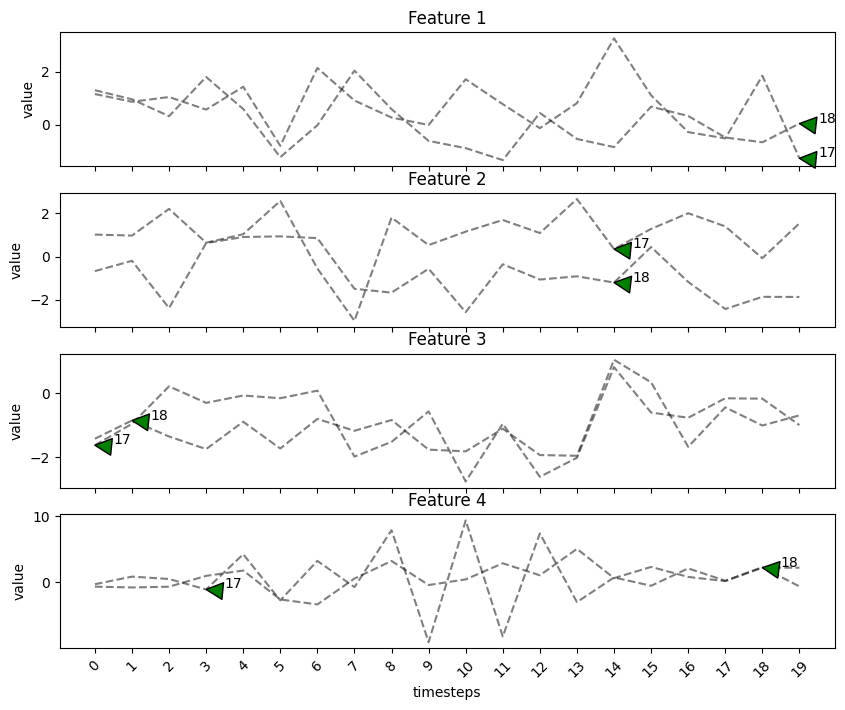

In [6]:
fig_ax = tsp.plot(X=ts_arr, entity_idx=[17, 18], show_all_entities=False, figsize=(10, 8))

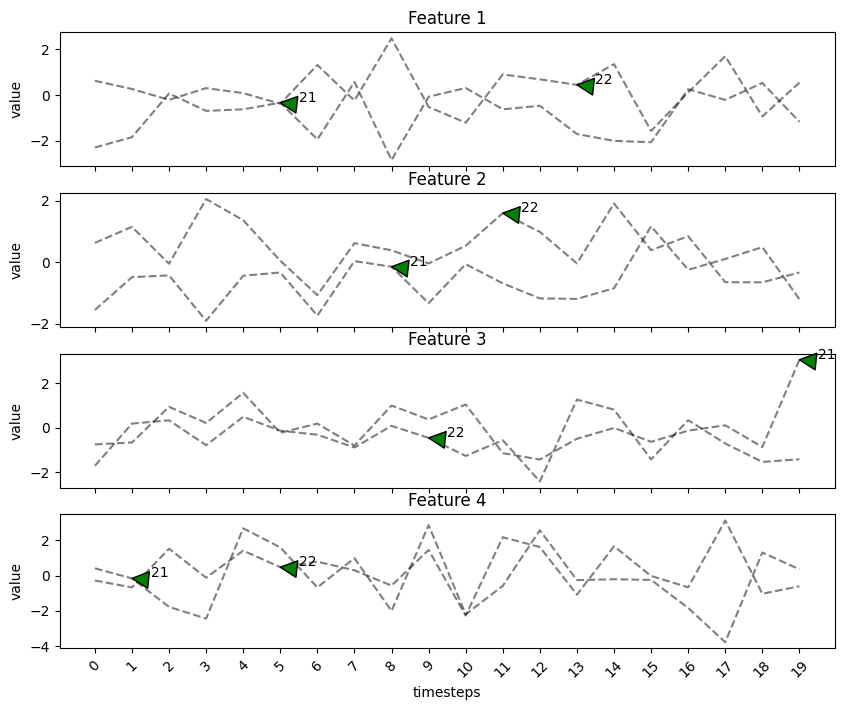

In [7]:
fig_ax = tsp.plot(X=ts_arr, entity_idx=[21, 22], show_all_entities=False, figsize=(10, 8))

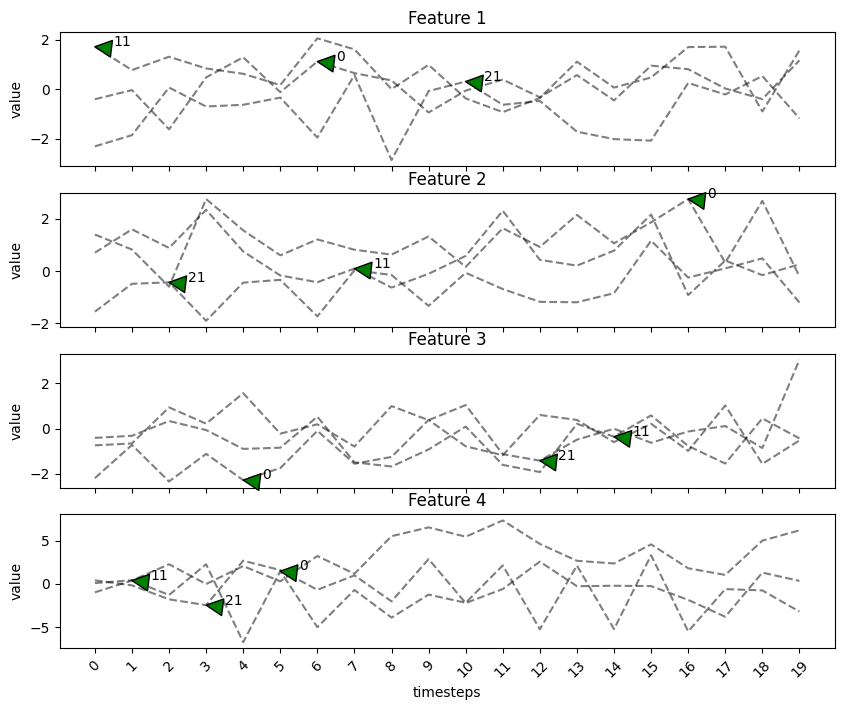

In [8]:
fig_ax = tsp.plot(X=ts_arr, entity_idx=[0, 11, 21], show_all_entities=False, figsize=(10, 8))

# GCT

In [11]:
gct = GrangeCausalTree(k=3, maxlag=2)
gct.fit(ts_arr)

In [12]:
# GC_PTSC(ts_arr, maxlag=2, k=3, lambda_reg=0, p_value_threshold=None, use_agg_clustering=False, return_total_models=True)

In [15]:
gct.labels_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 2., 2., 2., 2., 2., 0., 2., 2., 2., 2., 0., 2., 2., 2.,
       2., 0., 2., 2., 2., 2., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [14]:
gct.important_feature_set

{0: (0, 1), 1: (2,), 2: (0,)}

In [16]:
true_labels = np.array(sum([[i]*entities_per_cluster for i in range(K)], start=[]))
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [17]:
def par_set_accuracy(true_set, pred_set, true_labels, pred_labels):
    return np.sum([true_set[true_labels[i]] == pred_set[pred_labels[i]] for i in range(len(true_labels))]) / len(true_labels)


In [18]:
def calculate_purity(y_true, y_pred):
    # Compute the confusion matrix
    contingency_matrix = confusion_matrix(y_true, y_pred)
    
    # Find the maximum values along the columns and sum them
    max_contingency_sum = np.sum(np.amax(contingency_matrix, axis=0))
    
    # Divide by the number of samples to get the purity score
    purity = max_contingency_sum / np.sum(contingency_matrix)
    
    return purity

# Test

In [214]:
def create_design_data(X, maxlag, y_col_idx, fit_intercept):
    F = X.shape[1]

    feature_col_mask = np.array([True] * F)
    feature_col_mask[y_col_idx] = False 
    
    
    Xi = X[:, feature_col_mask].copy()
    Xi_u = create_lag_features(Xi[:-1, :], maxlag, add_constant=fit_intercept)
    Xi_r = create_lag_features(X[:-1, [y_col_idx]].copy(), maxlag, add_constant=fit_intercept)

    if fit_intercept:
        Xi_u = np.hstack([Xi_r[:, :-1], Xi_u]) # ensure that the ones for the constant coef is included once.
    else:
        Xi_u = np.hstack([Xi_r, Xi_u])

    yi = X[maxlag:, [y_col_idx]].copy()

    return Xi_u, Xi_r, yi

def cal_local_lr_theta(cov_x_lst, cov_xy_lst):
    return np.matmul(np.linalg.inv(np.sum(np.array(cov_x_lst), axis=0)), np.sum(np.array(cov_xy_lst), axis=0))

def cal_rss(X, y, theta):
    e = y - np.matmul(X, theta)

    return np.matmul(e.T, e).flatten()[0]

def cal_lr(X_u, X_r, y, theta_u, theta_r, scheme, return_rss=False):
    if scheme == 'global':
        total_rss_u = cal_rss(X_u, y, theta_u)
        total_rss_r = cal_rss(X_r, y, theta_r)

        lrs = np.log(total_rss_u) - np.log(total_rss_r)

    elif scheme == 'local':
        lrs = 0
        total_rss_u = 0
        total_rss_r = 0

        for i in range(len(X_u)):
            rss_u = cal_rss(X_u[i], y[i], theta_u)
            rss_r = cal_rss(X_r[i], y[i], theta_r)

            lrs += np.log(rss_u) - np.log(rss_r)

            total_rss_u += rss_u
            total_rss_r += rss_r

    if return_rss:
        return lrs, (total_rss_u, total_rss_r)
    
    return lrs

def optimize_theta(
    X: npt.NDArray[np.float64] | npt.NDArray[np.int64],
    maxlag: int,
    scheme: str = 'local',
    y_col_idx: int = -1,
    fit_intercept: bool = True,
    lambda_reg: float = 0, 
    return_rss: bool = False,
    get_model_size: bool = False,
    **kwargs
    ):

    T, N, F = X.shape

    # if y_col_idx == -1:
    #     y_col_idx = F - 1

    X_u_lst = []
    X_r_lst = []
    y_lst = []

    cov_x_u_lst = []
    cov_xy_u_lst = []

    cov_x_r_lst = []
    cov_xy_r_lst = []


    for i in range(N):
        Xi = X[:, i, :].copy()
        
        Xi_u, Xi_r, yi = create_design_data(Xi, maxlag=maxlag, y_col_idx=y_col_idx, fit_intercept=fit_intercept)

        X_u_lst.append(Xi_u)
        X_r_lst.append(Xi_r)
        
        y_lst.append(yi)
        
        if scheme == 'local':
            Xi_u_T = Xi_u.T
            Xi_r_T = Xi_r.T

            cov_x_u_lst.append(np.matmul(Xi_u_T, Xi_u))
            cov_xy_u_lst.append(np.matmul(Xi_u_T, yi))
            
            cov_x_r_lst.append(np.matmul(Xi_r_T, Xi_r))
            cov_xy_r_lst.append(np.matmul(Xi_r_T, yi))

    if scheme == 'global' or scheme == 'rss_unrestricted':
        X_u_lst = np.vstack(X_u_lst)
        X_u_lst_T = X_u_lst.T

        cov_x_u_lst.append(np.matmul(X_u_lst_T, X_u_lst) + lambda_reg * np.identity(X_u_lst.shape[1]))

        y_lst = np.vstack(y_lst)

        cov_xy_u_lst.append(np.matmul(X_u_lst_T, y_lst))

        if scheme != 'rss_unrestricted':
            X_r_lst = np.vstack(X_r_lst)
            X_r_lst_T = X_r_lst.T

            cov_x_r_lst.append(np.matmul(X_r_lst_T, X_r_lst) + lambda_reg * np.identity(X_r_lst.shape[1]))

            cov_xy_r_lst.append(np.matmul(X_r_lst_T, y_lst))

    theta_u = cal_local_lr_theta(cov_x_u_lst, cov_xy_u_lst)

    if scheme == 'rss_unrestricted':
        return theta_u, cal_rss(X_u_lst, y_lst, theta_u) + lambda_reg * np.linalg.norm(theta_u)
    
    theta_r = cal_local_lr_theta(cov_x_r_lst, cov_xy_r_lst)

    results = cal_lr(X_u_lst, X_r_lst, y_lst, theta_u, theta_r, scheme=scheme, return_rss=return_rss)

    if return_rss:
        return theta_u, results[0], theta_r, results[1]
    
    return theta_u, results, theta_r

In [216]:
K = 3
true_labels = np.array(sum([[i]*entities_per_cluster for i in range(K)], start=[]))
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

# Base Case

In [86]:
def kmeans_b4_modelling(X, K, maxlag, metric='euclidean', alpha=0.1, fit_intercept=False, verbose=True, random_state=None):
    ts_kmeans = TSKmeans(n_clusters=K, metric=metric, random_state=random_state)
    ts_kmeans.fit(X)
    labels = ts_kmeans.labels_

    if verbose:
        print(f"Labels are {labels}")
    
    _, N, F = X.shape

    theta_us = []

    t0 = time.time()
    for i in range(K):

        Xi = ts_kmeans.cluster_centers_[:, i, :]

        Xi_u, _, yi = create_design_data(Xi, maxlag=maxlag, y_col_idx=-1, fit_intercept=False) # sklearn's regression has coef_ and intercept_ attributes 
                                                                                               # for coef and intercept

        lasso_reg = Lasso(alpha=alpha, fit_intercept=fit_intercept) 
        lasso_reg.fit(Xi_u, yi)

        theta = lasso_reg.coef_ # sklearn's regression has coef_ and intercept_ attributes for coef and intercept

        # end_idx = -1 if fit_intercept else len(theta)

        theta = set(np.array([np.arange(0, F-1)] * maxlag).T.flatten()[np.abs(theta[maxlag:]) > 0]) # empty set could mean only the lag values of  
                                                                                                    # the target time series are important

        if len(theta) == 0:
            theta = {-1}

        theta = tuple(sorted(list(theta)))

        theta_us.append(theta)

    theta_us = dict(enumerate(theta_us))

    if verbose:

        print()
        print(f"Done after {np.round(time.time() - t0, 2)}secs")

    return labels, theta_us

In [87]:
K = 3
maxlag = 2
metric = 'euclidean'
alpha = 0.1

labels, theta_us = kmeans_b4_modelling(ts_arr, K=K, maxlag=maxlag, alpha=alpha, metric=metric, fit_intercept=True)

Labels are [2 1 0 2 2 2 0 0 0 2 1 2 1 0 0 2 2 0 1 2 0 2 0 1 2 1 2 2 0 1 1 2 1 0 2 1 1
 2 2 2 0 0 2 0 1 2 1 1 0 2 0 1 1 0 0 2 2 1 0 0]

Done after 0.01secs


In [88]:
labels

array([2, 1, 0, 2, 2, 2, 0, 0, 0, 2, 1, 2, 1, 0, 0, 2, 2, 0, 1, 2, 0, 2,
       0, 1, 2, 1, 2, 2, 0, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 0, 0, 2, 0,
       1, 2, 1, 1, 0, 2, 0, 1, 1, 0, 0, 2, 2, 1, 0, 0], dtype=int64)

In [89]:
theta_us

{0: (-1,), 1: (-1,), 2: (-1,)}

Problem with this method is that two clusters may be in the same class

# Most similar coefficient

In [97]:
def most_similar_coef(X, K, maxlag, fit_intercept=False, verbose=True, random_state=None, use_max_lag_coef=False, clust_abs_val=False):
    _, N, F = X.shape

    theta_us = []
    # theta_rs = []

    X_u_lst = []
    # X_r_lst = []
    y_lst = []

    t0 = time.time()
    for i in range(N):
        cov_x_u_lst = []
        cov_xy_u_lst = []

        # cov_x_r_lst = []
        # cov_xy_r_lst = []

        Xi = X[:, i, :]

        Xi_u, _, yi = create_design_data(Xi, maxlag=maxlag, y_col_idx=-1, fit_intercept=fit_intercept)

        Xi_u_T = Xi_u.T
        # Xi_r_T = Xi_r.T

        cov_x_u_lst.append(np.matmul(Xi_u_T, Xi_u))
        cov_xy_u_lst.append(np.matmul(Xi_u_T, yi))

        # cov_x_r_lst.append(np.matmul(Xi_r_T, Xi_r))
        # cov_xy_r_lst.append(np.matmul(Xi_r_T, yi))

        theta_us.append(cal_local_lr_theta(cov_x_u_lst, cov_xy_u_lst).flatten())
        # theta_rs.append(cal_local_lr_theta(cov_x_r_lst, cov_xy_r_lst).flatten())

        X_u_lst.append(Xi_u)
        # X_r_lst.append(Xi_r)
        y_lst.append(yi)

    theta_us = np.array(theta_us)

    if fit_intercept:
        theta_us = theta_us[:, :-1]

    theta_us = theta_us[:, maxlag:] # removing target feature
    # theta_rs = np.array(theta_rs)

    if use_max_lag_coef:
        # F -= 1 # since target has been ignored
        theta_us_lst = []
        for f in range(F-1): # since target has been ignored
            theta_us_lst.append(np.max(np.abs(theta_us[:, f*maxlag: (f+1)*maxlag]), axis=1))

        theta_us = np.array(theta_us_lst).T

    km_u = KMeans(K, random_state=random_state)
    # km_r = KMeans(K, random_state=random_state)

    if clust_abs_val:
        theta_us = np.abs(theta_us)
    km_u.fit(theta_us) #/ np.linalg.norm(theta_us, axis=1).reshape(-1, 1)) # # remove the intercept because they are the same
    # km_r.fit(theta_rs[:, :])

    theta_u = km_u.cluster_centers_ #np.hstack([km_u.cluster_centers_, np.ones((K, 1))])
    # theta_r = km_r.cluster_centers_ #np.hstack([km_r.cluster_centers_, np.ones((K, 1))])

    theta_bool = theta_u > np.mean(theta_u, axis=1).reshape(-1, 1)
    feature_lag_lst = np.array(sum([[i]*maxlag for i in range(F-1)], []))

    theta_u = {k: tuple(np.unique(feature_lag_lst[theta_bool[k]])) for k in range(theta_bool.shape[0])}
    
    labels = km_u.labels_ 
    # C = np.zeros((N, K))

    # C[np.arange(N), labels] = 1 

    # rss_total = 0

    # for j in range(K):
    #     i_mask = np.argmax(C, axis=1) == j
    #     X_u_j = list(np.array(X_u_lst)[i_mask, :, :])
    #     X_r_j = list(np.array(X_r_lst)[i_mask, :, :])
    #     y_j = list(np.array(y_lst)[i_mask, :, :])

    #     _, rss_ = cal_lr(X_u_j, X_r_j, y_j, theta_u[j].reshape(-1, 1), theta_r[j].reshape(-1, 1), 
    #                        scheme='local', return_rss=True)
    
    #     rss_total += rss_[0]

    if verbose:
        # print(f"Done! rss = {rss_total}")

        print()
        print(f"Done after {np.round(time.time() - t0, 2)}secs")

    return labels, theta_u #, C, rss_total

In [98]:
K = 3

maxlag = 2

labels, theta_us = most_similar_coef(ts_arr, K=K, maxlag=maxlag, fit_intercept=True, use_max_lag_coef=0, clust_abs_val=1)
labels


Done after 0.23secs


array([2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [99]:
calculate_purity(true_labels, labels)

0.9833333333333333

In [100]:
theta_us

{0: (0,), 1: (2,), 2: (0, 1)}

In [101]:
# vars = ['C', 'A', 'B']

# for j in range(K):
#     equ_str = f"Cluster {j}: "

#     coef_str_lst = []

#     theta_j = theta_u[j].flatten()

#     if fit_intercept:
#         n_par = len(theta_j) - 1
#         intercept_str = f"+ {np.round(theta_j[-1], 4)}"
#     else:
#         n_par = len(theta_j)
#         intercept_str = ""

#     for coef_f in range(n_par):
#         var_i, lag_i = np.unravel_index(coef_f, (len(vars), maxlag))

#         coef_str_lst.append(f"{np.round(theta_j[coef_f], 4)} {vars[var_i]}_{lag_i+1} ")

#     # coef_str_lst = sorted(coef_str_lst, key=lambda x: -1 * np.abs(float(x.split(' ')[0])))

#     coef_str_lst = sorted(coef_str_lst, key=lambda x: 
#                           (x.split(' ')[1].split('_')[0], -1 * int(x.split(' ')[1].split('_')[1])), 
#                           reverse=True)
    
#     equ_str += " + ".join(coef_str_lst)

#     equ_str += intercept_str

#     print(equ_str)
#     print()

In [102]:
print("Cluster 0: 0.17 C_1 + 0.022 C_2 + 0.32 B_1  + 0.25 B_2  + 0.01 A_1  + 0.05 A_2 = C")

print("Cluster 1: 0.27 C_1 + 0.11 C_2  + 0.02 B_1 + 0.014 B_2   + 0.34 A_1 + 0.15 A_2  = C")

print("Cluster 2: 0.09 C_1  + 0.11 C_2 + 0.23 B_1 + 0.04 B_2 + 0.25 A_1  + 0.01 A_2  = C")

Cluster 0: 0.17 C_1 + 0.022 C_2 + 0.32 B_1  + 0.25 B_2  + 0.01 A_1  + 0.05 A_2 = C
Cluster 1: 0.27 C_1 + 0.11 C_2  + 0.02 B_1 + 0.014 B_2   + 0.34 A_1 + 0.15 A_2  = C
Cluster 2: 0.09 C_1  + 0.11 C_2 + 0.23 B_1 + 0.04 B_2 + 0.25 A_1  + 0.01 A_2  = C


In [103]:
# calculate_purity(true_labels, np.argmax(C, axis=1))

# Clustering Lasso Coefficients

In [104]:
def clustering_lasso_coef(X, K, maxlag, alpha=0.1, fit_intercept=True, verbose=True):
    _, N, F = X.shape

    theta_us = []

    for i in range(N):

        Xi = X[:, i, :]

        Xi_u, _, yi = create_design_data(Xi, maxlag=maxlag, y_col_idx=-1, fit_intercept=False) # sklearn's regression has coef_ and intercept_ 
                                                                                               # attributes for coef and intercept

        lasso = Lasso(alpha=alpha, fit_intercept=fit_intercept)
        lasso.fit(Xi_u, yi)

        theta = lasso.coef_
        theta = set(np.array([np.arange(0, F-1)] * maxlag).T.flatten()[np.abs(theta[maxlag:]) > 0]) # empty set could mean only the lag values of  
                                                                                                # the target time series are important

        if len(theta) == 0: # empty set could mean only the lag values of the target time series are important, so we use -1 as the class
            theta = {-1}

        theta = ' '.join(list(map(str, sorted(list(theta)))))
        
        theta_us.append(theta)

    vectorizer = CountVectorizer(binary=True, tokenizer=lambda x: x.split())

    # Fit and transform the data
    one_hot_encoded = vectorizer.fit_transform(theta_us).toarray()
    feature_names = vectorizer.get_feature_names_out()

    jaccard_dist = pairwise_distances(one_hot_encoded, metric='jaccard')

    # Perform Agglomerative Clustering with Jaccard distance
    agg_clust = AgglomerativeClustering(n_clusters=K, metric='precomputed', linkage='average')

    agg_clust.fit(jaccard_dist)

    labels = agg_clust.labels_

    # most common important feature set is the class for a cluster
    theta_us = []
    for j in range(K):
        list_of_feature_set = list(map(lambda row: ' '.join(feature_names[row == 1]), one_hot_encoded[labels == j, :]))

        counter = Counter(list_of_feature_set)
        theta_us.append(tuple(sorted(map(int, list(set(counter.most_common(1)[0][0].split()))))))

    theta_us = dict(enumerate(theta_us))

    return labels, theta_us

In [105]:
K = 3

maxlag = 2

labels, theta_us = clustering_lasso_coef(ts_arr, K=K, maxlag=maxlag, alpha=0.1, fit_intercept=True)
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [106]:
theta_us

{0: (0, 1, 2), 1: (2,), 2: (0,)}

In [107]:
vectorizer = CountVectorizer(binary=True, tokenizer=lambda x: x.split())

# Fit and transform the data
one_hot_encoded = vectorizer.fit_transform(['0 1 2', '0 1 2', '-1', '2', '2', '2', '0 1']).toarray()
features = vectorizer.get_feature_names_out()
print(features)
one_hot_encoded, features

['-1' '0' '1' '2']


(array([[0, 1, 1, 1],
        [0, 1, 1, 1],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 1, 1, 0]], dtype=int64),
 array(['-1', '0', '1', '2'], dtype=object))

In [108]:
jaccard_dist = pairwise_distances(one_hot_encoded, metric='jaccard')
jaccard_dist

array([[0.        , 0.        , 1.        , 0.66666667, 0.66666667,
        0.66666667, 0.33333333],
       [0.        , 0.        , 1.        , 0.66666667, 0.66666667,
        0.66666667, 0.33333333],
       [1.        , 1.        , 0.        , 1.        , 1.        ,
        1.        , 1.        ],
       [0.66666667, 0.66666667, 1.        , 0.        , 0.        ,
        0.        , 1.        ],
       [0.66666667, 0.66666667, 1.        , 0.        , 0.        ,
        0.        , 1.        ],
       [0.66666667, 0.66666667, 1.        , 0.        , 0.        ,
        0.        , 1.        ],
       [0.33333333, 0.33333333, 1.        , 1.        , 1.        ,
        1.        , 0.        ]])

In [109]:
# Perform Agglomerative Clustering with Jaccard distance
clustering = AgglomerativeClustering(
    n_clusters=3,          # Number of clusters
    metric='precomputed', # Use precomputed distance matrix
    linkage='average'       # Linkage method ('average', 'complete', 'single', etc.)
)

clustering.fit(jaccard_dist)

# Print cluster labels
l = clustering.labels_
l

array([0, 0, 1, 2, 2, 2, 0], dtype=int64)

In [110]:
for j in range(3):
    a = list(map(lambda row: ' '.join(features[row == 1]), one_hot_encoded[l == j, :]) )
    print(a)
    break 
counter = Counter(a)
most_common_item = tuple(sorted(map(int, list(set(counter.most_common(1)[0][0].split())))))
most_common_item

['0 1 2', '0 1 2', '0 1']


(0, 1, 2)

# Comparison

In [111]:
def avg_coef_distance(true_coef, pred_coef, use_cosine=False, p=2):
    # cal distance matrix
    coef_dist_matrix = []
    for i in range(true_coef.shape[0]):
        if use_cosine:
            cosine_distances = []
            for j in range(pred_coef.shape[0]):
                a = true_coef[i, :]
                b = pred_coef[j, :]
                dot_product = np.dot(a, b)
                norm_a = np.linalg.norm(a)
                norm_b = np.linalg.norm(b)
                cosine_similarity = dot_product / (norm_a * norm_b)
                 
                cosine_distances.append(1 - cosine_similarity)
                
            coef_dist_matrix.append(np.array(cosine_distances))

        else:
            coef_dist_matrix.append(np.linalg.norm(true_coef[[i], :] - pred_coef, ord=p, axis=1))

    coef_dist_matrix = np.array(coef_dist_matrix)
    
    cm = coef_dist_matrix.copy()

    # one to one mapping of most similar true to pred such that no two true clusters will map to the same pred
    most_similar_pred = np.zeros(coef_dist_matrix.shape[0], dtype=int)

    for _ in range(cm.shape[0]):
        row, col = np.unravel_index(np.argmin(cm), cm.shape)
        most_similar_pred[row] = col
        cm[:, col] = np.inf
        cm[row, :] = np.inf

    return np.mean(coef_dist_matrix[np.arange(cm.shape[0]), most_similar_pred])

In [112]:
# np.arange(C.shape[0])[np.argmax(C, axis=1) == 0]

In [113]:
def cal_PTSC_rss(X, theta_us, labels, maxlag, fit_intercept, y_col_idx=-1):
    N = X.shape[1]
    K = len(np.unique(labels))

    total_rss = 0

    for j in range(K):
        idx_mask = labels == j

        rss_per_j = []

        for i in np.arange(N)[idx_mask]:
            Xi = X[:, i, :]
            Xi_u, _, yi = create_design_data(Xi, maxlag=maxlag, y_col_idx=y_col_idx, fit_intercept=fit_intercept)

            rss_u = cal_rss(Xi_u, yi, theta_us[j])

            rss_per_j.append(rss_u)

        total_rss += np.sum(rss_per_j)

    return total_rss

In [114]:
    # [0.17, 0.022, 0.32, 0.25, 0.01, 0.05],# 1.04],
    # [0.27, 0.11, 0.02, 0.014, 0.34, 0.15],# 2.05],
    # [0.09, 0.11, 0.23, 0.04, 0.25, 0.01]#3.03]

#1.04, 2.05, 3.03
true_coef = np.array([
    [0.17, 0.022, 0.01, 0.05, 0.32, 0.25, 0],
    [0.27, 0.11, 0.34, 0.15, 0.02, 0.014, 0],
    [0.09, 0.11, 0.25, 0.01, 0.23, 0.04, 0]

])

fit_intercept = True

# theta_11s = [0.01, 0.34, 0.25]
# theta_12s = [0.05, 0.15, 0.01]

# theta_21s = [0.32, 0.02, 0.23]
# theta_22s = [0.25, 0.014, 0.04]

# theta_31s = [0.17, 0.27, 0.09]
# theta_32s = [0.022, 0.11, 0.11]

# print("Cluster 0: 0.17 C_1 + 0.022 C_2 + 0.32 B_1  + 0.25 B_2  + 0.01 A_1  + 0.05 A_2 = C")

# print("Cluster 1: 0.27 C_1 + 0.11 C_2  + 0.02 B_1 + 0.014 B_2   + 0.34 A_1 + 0.15 A_2  = C")

# print("Cluster 2: 0.09 C_1  + 0.11 C_2 + 0.23 B_1 + 0.04 B_2 + 0.25 A_1  + 0.01 A_2  = C")


## All other models

In [115]:
for i in range(5):
    rand_gen = np.random.RandomState(1)

    for _ in range(3):
        print(rand_gen.randint(low=0, high=100_000))

    print()

98539
77708
5192

98539
77708
5192

98539
77708
5192

98539
77708
5192

98539
77708
5192



### Changing target noise

#### Purity Score

In [20]:
K = 4
true_set = {0: (0, ), 1: (0, 1), 2: (1, 2), 3: (0, 1, 2)} # feature 3 is not important at all, target feature is 4
maxlag = 3
N = 80
entities_per_cluster = N // K
F = 4 
T = 50

def get_exp_results(
        noises,
        noise_type,
        K=K, 
        T=T, 
        N=N, 
        F=F, 
        n_lags=maxlag, 
        target_noise_sigma=0,
        par_noise_std=0,
        feature_noise_sigma=1, 
        true_set=true_set, 
        entities_per_cluster=entities_per_cluster, 
        fit_intercept=True,
        random_state=None, 
        is_target_gc=False
        ):
        
    models = ['GC-PTSC', 'GC-PTSC-0.05', 'most_similar_abs_coef', 'clustering_lasso_coef', 'kmeans_b4_modelling_l2'][::-1]
    model_names = ['GCT', 'GCT-0.05', 'KMW', 'Agg-LR', 'AR-TSC'][::-1]

    # par_accuracy_models = ['GC-PTSC', 'GC-PTSC-0.05', 'most_similar_abs_coef', 'clustering_lasso_coef', 'kmeans_b4_modelling_l2'] # 'jrc_lasso',
    # par_accuracy_model_names = [model_names[i] for i in range(len(models)) if models[i] in par_accuracy_models]

    purity = []
    par_acc_score = []
    percent_total_models_used = []
    avg_set_lens = []

     

    counter = 0

    true_labels = np.array(sum([[i]*entities_per_cluster for i in range(K)], start=[]))

    for noise in noises:

        if noise_type == 'target':
            target_noise_sigma = noise 
        elif noise_type == 'par':
            par_noise_std = noise

        ts_arr = gen_synthetic_data(K=K, T=T, N=N, F=F, n_lags=n_lags, target_noise_sigma=target_noise_sigma, 
                                    par_noise_std=par_noise_std, feature_noise_sigma=feature_noise_sigma,
                                    true_set=true_set, entities_per_cluster=entities_per_cluster, 
                                    random_state=random_state, is_target_gc=is_target_gc
                                    )
        
        noise_purity = []
        noise_par_set_acc = []
        avg_set_len = []

        for model in models:

            # rand_gen = np.random.RandomState(0)

            model_results = []
            # try:

            if model == 'kmeans_b4_modelling_l2':
                m = ARTSC(k=K, maxlag=maxlag, random_state=random_state, fit_intercept=fit_intercept, metric='euclidean')

                # kmeans_b4_modelling(ts_arr, K=K, maxlag=maxlag, random_state=random_state, fit_intercept=fit_intercept,
                #                                             metric='euclidean', verbose=False)
                
            elif model == 'most_similar_abs_coef':
                m = KMW(k=K, maxlag=maxlag, random_state=random_state, fit_intercept=fit_intercept, alpha=0.1)
                # labels, theta_us = most_similar_coef(ts_arr, K=K, maxlag=maxlag, verbose=False, random_state=random_state, fit_intercept=fit_intercept,
                #                                      clust_abs_val=True)

            elif model == 'clustering_lasso_coef':
                m = AggLR(k=K, maxlag=maxlag, fit_intercept=fit_intercept, alpha=0.1)
                # labels, theta_us = clustering_lasso_coef(ts_arr, K=K, maxlag=maxlag, fit_intercept=fit_intercept, verbose=False)
                
            elif model == 'GC-PTSC':
                m = GrangeCausalTree(k=K, maxlag=maxlag, fit_intercept=fit_intercept, p_value_threshold=None, lambda_reg=0)
                # labels, theta_us = GC_PTSC(ts_arr, maxlag=maxlag, k=K, p_value_threshold=None)

            elif model == 'GC-PTSC-0.05':
                m = GrangeCausalTree(k=K, maxlag=maxlag, fit_intercept=fit_intercept, p_value_threshold=0.05, lambda_reg=0)
                # labels, theta_us = GC_PTSC(ts_arr, maxlag=maxlag, k=K, p_value_threshold=0.05, use_agg_clustering=False)

            m.fit(ts_arr)
            labels = m.labels_
            theta_us = m.important_feature_set_ 

            if model in ('GC-PTSC', 'GC-PTSC-0.05'):
                avg_set_len.append(np.mean(list(map(lambda j: len(theta_us[j]), labels))))

                if model == 'GC-PTSC':
                    nm, nm_max = m.n_trained_models_
                    percent_total_models_used.append(nm / nm_max)

            # except ValueError: # possibly due to empty cluster
            #     print(f"init {init_} failed for model {model}")
            #     continue

            pur = calculate_purity(true_labels, labels)

            # if model in par_accuracy_models:
            par_acc = par_set_accuracy(true_set=true_set, pred_set=theta_us, true_labels=true_labels, pred_labels=labels)
            # else: 
            #     par_acc = np.nan

            model_results.append((pur, par_acc))

            # if model in ['GC-PTSC', 'clustering_lasso_coef']:
            #     break 
        
            best_idx = np.argmax([res[0] for res in model_results])
            pur, par_acc = model_results[best_idx]
            noise_purity.append(pur)
            
            # if model in par_accuracy_models:
            noise_par_set_acc.append(par_acc)

        purity.append(noise_purity)
        par_acc_score.append(noise_par_set_acc)
        avg_set_lens.append(avg_set_len)

        counter += 1
        print(f"Done with {counter} of {len(noises)}")

    # RSSs = np.array(RSSs)
    purity = np.array(purity)
    par_acc_score = np.array(par_acc_score)
    avg_set_lens = np.array(avg_set_lens)
    percent_total_models_used = np.array(percent_total_models_used)

    return model_names, purity, par_acc_score, avg_set_lens, percent_total_models_used

In [21]:
noises = np.linspace(0, 1, 10)

model_names, purity, par_acc_score, avg_set_lens, percent_total_models_used = get_exp_results(
                                                                                                noises, 
                                                                                                'target', 
                                                                                                random_state=0
                                                                                                )

Done with 1 of 10
Done with 2 of 10
Done with 3 of 10
Done with 4 of 10
Done with 5 of 10
Done with 6 of 10
Done with 7 of 10
Done with 8 of 10
Done with 9 of 10
Done with 10 of 10


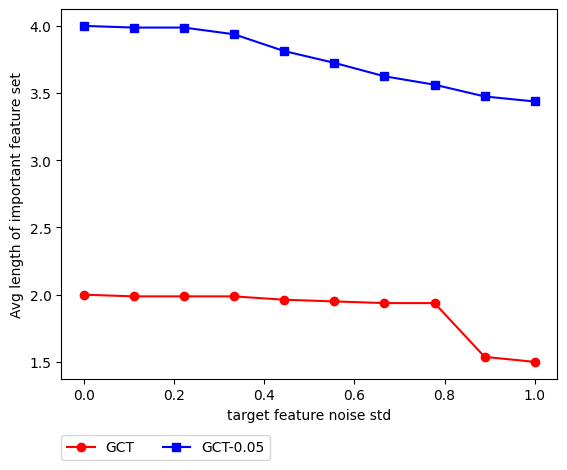

In [22]:
markers = ['o', 's'][::-1]
colors = ['red', 'blue'][::-1]
GCT_models = ['GCT', 'GCT-0.05'][::-1]

fig = plt.figure()
for m in range(len(GCT_models)):
    plt.plot(noises, avg_set_lens[:, m], label=GCT_models[m], marker=markers[m], color=colors[m])

# plt.ylim(0, 1.1)
plt.legend(loc=(0, -0.22), ncol=2, reverse=1)
plt.xlabel('target feature noise std')
plt.ylabel('Avg length of important feature set')
# plt.title('Avg length of important feature set vs Std of Noise ($\delta_{ijp}$) added to the parameter of each lag feature of each Entity')
plt.savefig('avg_set_len.svg', bbox_inches='tight')
plt.show()

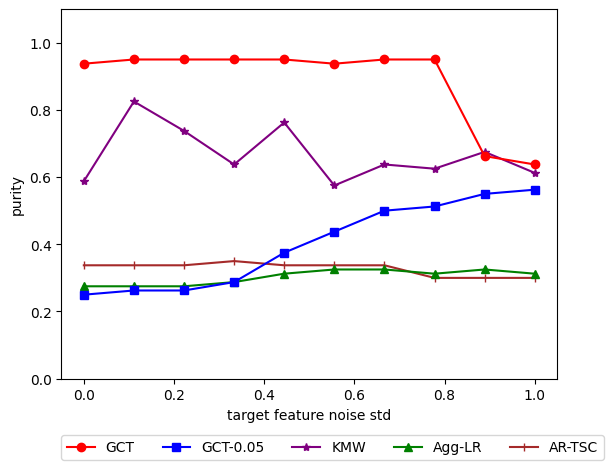

In [23]:
markers = ['o', 's', '*', '^', '|'][::-1]
colors = ['red', 'blue', 'purple', 'green', 'brown'][::-1]

fig = plt.figure()
for m in range(len(model_names)):
    plt.plot(noises, purity[:, m], label=model_names[m], marker=markers[m], color=colors[m])

plt.ylim(0, 1.1)
plt.legend(loc=(0, -0.22), ncol=5, reverse=1)
plt.xlabel('target feature noise std')
plt.ylabel('purity')
# plt.title('Purity vs Std of Noise ($e_i$) added to the Target Feature of each Entity')
plt.savefig('purity.svg', bbox_inches='tight')
plt.show()

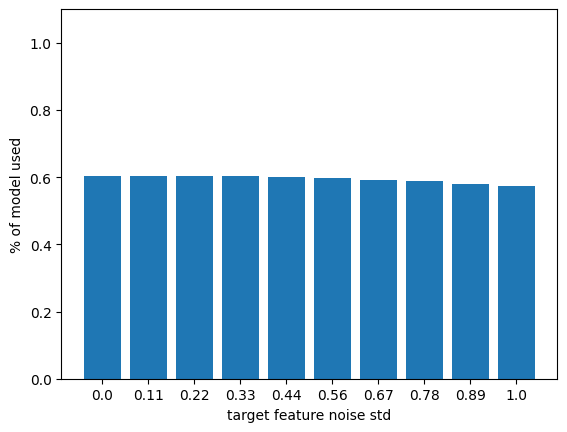

In [24]:
# markers = ['s', '^', 'D', '|', '*'][::-1]

fig = plt.figure()
# for m in range(len(models)):
plt.bar(list(map(str, np.round(noises, 2))), percent_total_models_used)

plt.ylim(0, 1.1)
# plt.legend(loc=(1.01, 0))
plt.xlabel('target feature noise std')
plt.ylabel(r"% of model used")
# plt.title('% of models (trained using GCT) vs Std of Noise added to the Target Feature')
plt.savefig('percent_model_used.svg', bbox_inches='tight')
plt.show()

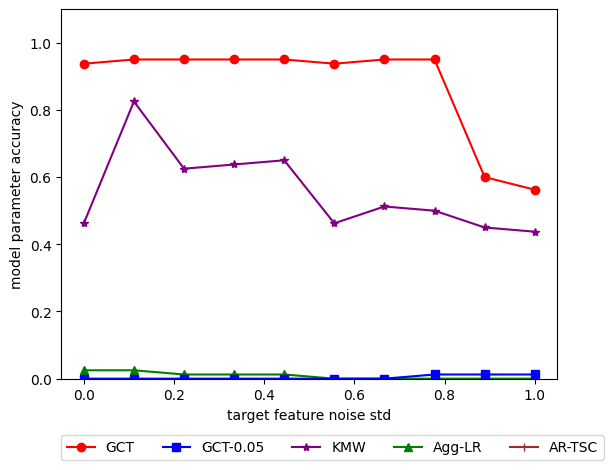

In [25]:
# markers = ['s', '^', '*', '|', '.'][::-1]

fig = plt.figure()
for m in range(len(model_names)):
    plt.plot(noises, par_acc_score[:, m], label=model_names[m], marker=markers[m], color=colors[m])

plt.ylim(0, 1.1)
plt.legend(loc=(0, -0.22), ncol=5, reverse=1)
plt.xlabel('target feature noise std')
plt.ylabel('model parameter accuracy')
# plt.title('Accuracy of important feature set vs Std of Noise ($e_i$) added to the Target Feature of each Entity')
plt.savefig('accuracy_feature_set.svg', bbox_inches='tight')
plt.show()

### Changing par std

#### Purity Score

In [27]:
noises = np.linspace(0, 0.3, 10)

model_names, purity, par_acc_score, avg_set_lens, percent_total_models_used = get_exp_results(
                                                                                                noises, 
                                                                                                'par', 
                                                                                                random_state=0
                                                                                                )

Done with 1 of 10
Done with 2 of 10
Done with 3 of 10
Done with 4 of 10
Done with 5 of 10
Done with 6 of 10
Done with 7 of 10
Done with 8 of 10
Done with 9 of 10
Done with 10 of 10


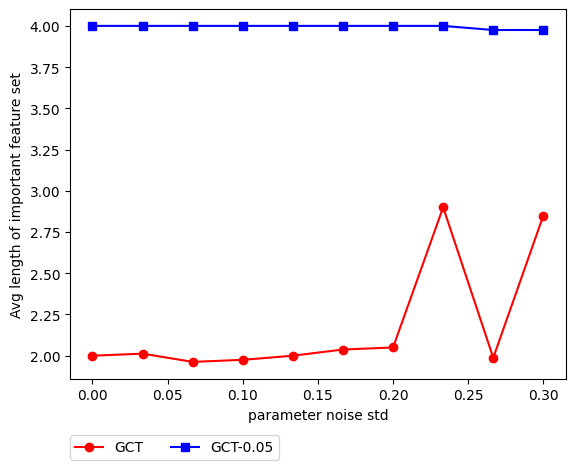

In [29]:
markers = ['o', 's'][::-1]
colors = ['red', 'blue'][::-1]
GCT_models = ['GCT', 'GCT-0.05'][::-1]

fig = plt.figure()
for m in range(len(GCT_models)):
    plt.plot(noises, avg_set_lens[:, m], label=GCT_models[m], marker=markers[m], color=colors[m])

# plt.ylim(0, 1.1)
plt.legend(loc=(0, -0.22), ncol=2, reverse=1)
plt.xlabel('parameter noise std')
plt.ylabel('Avg length of important feature set')
# plt.title('Avg length of important feature set vs Std of Noise ($\delta_{ijp}$) added to the parameter of each lag feature of each Entity')
plt.savefig('avg_set_len2.svg', bbox_inches='tight')
plt.show()

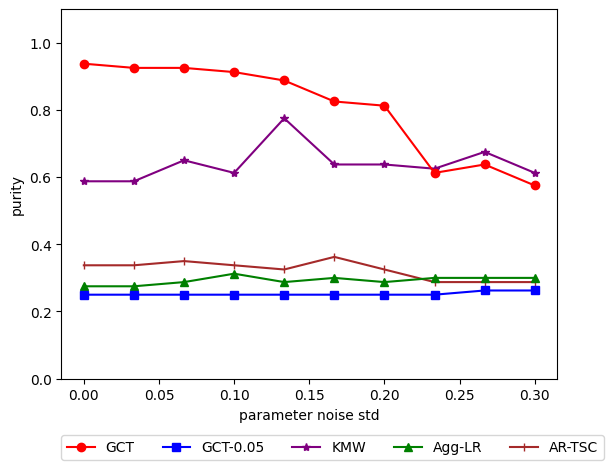

In [30]:
markers = ['o', 's', '*', '^', '|'][::-1]
colors = ['red', 'blue', 'purple', 'green', 'brown'][::-1]

fig = plt.figure()
for m in range(len(model_names)):
    plt.plot(noises, purity[:, m], label=model_names[m], marker=markers[m], color=colors[m])

plt.ylim(0, 1.1)
plt.legend(loc=(0, -0.22), ncol=5, reverse=1)
plt.xlabel('parameter noise std')
plt.ylabel('purity')
# plt.title('Purity vs Std of Noise ($\delta_{ijp}$) added to the parameter of each lag feature of each Entity')
# plt.savefig('purity2.svg', bbox_inches='tight')
plt.show()

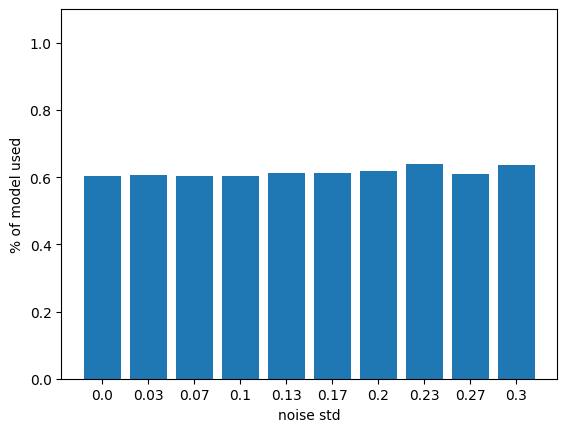

In [31]:
fig = plt.figure()
# for m in range(len(models)):
plt.bar(list(map(str, np.round(noises, 2))), percent_total_models_used)

plt.ylim(0, 1.1)
# plt.legend(loc=(1.01, 0))
plt.xlabel('noise std')
plt.ylabel(r"% of model used")
# plt.title('% of models (trained using GCT) vs Std of Noise added to the Target Feature')
plt.savefig('percent_model_used_2.svg', bbox_inches='tight')
plt.show()

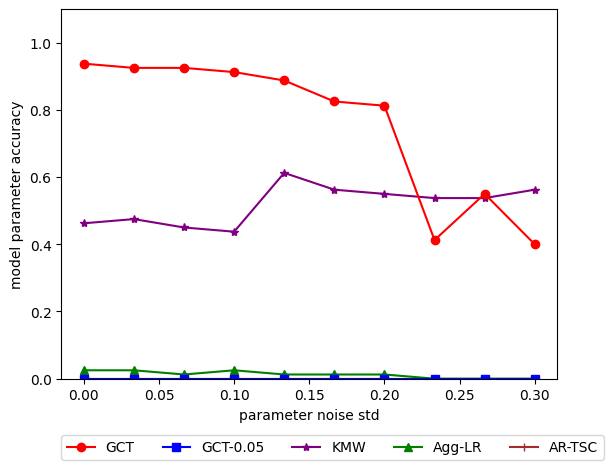

In [32]:
# markers = ['s', '*', '*', '|', '.'][::-1]

fig = plt.figure()
for m in range(len(model_names)):
    plt.plot(noises, par_acc_score[:, m], label=model_names[m], marker=markers[m], color=colors[m])

plt.ylim(0, 1.1)
plt.legend(loc=(0, -0.22), ncol=5, reverse=1)
plt.xlabel('parameter noise std')
plt.ylabel('model parameter accuracy')
# plt.title('Acuracy of Important Feature Set vs Std of Noise ($\delta_{ijp}$) added to the parameter of each lag feature of each Entity')
# plt.savefig('accuracy_feature_set2.svg', bbox_inches='tight')
plt.show()